# VGG11, 13, 16, 19
VGG11, 13, 16, and 19 are famous neural networks that achieved high test accuracies in ImageNet, which contains more than 14 million training images with 1000 object classes. It has differing amounts of convolutional layers with different sizes, max pooling, and 3 fully-connected layers at the end. No batch normalization or dropout.

VGG refers to the Visual Geometry Group, which is Andrew Zisserman's lab. The numbers represent how many layers the network has.

Karen Simonyan, and Andrew Zisserman. “Very Deep Convolutional Networks for Large-Scale Image Recognition.” 3rd International Conference on Learning Representations (ICLR 2015), Computational and Biological Learning Society, 2015
![vggtable](res/VGGtable.png)

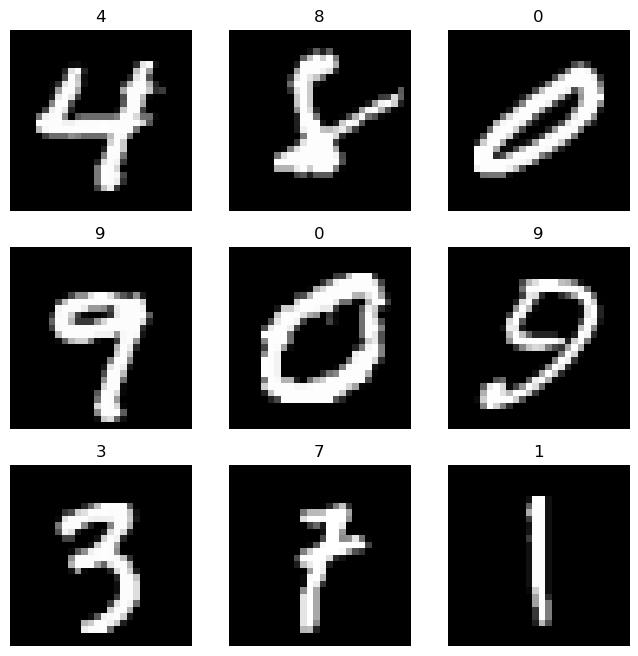

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

# Show some data
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Choose Device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### Dataloaders

In [3]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


#### Define Model
This uses a small network inspired from the VGG architecture. 

In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), # 28 x 28
    nn.MaxPool2d(kernel_size=2, stride=2), # 14 x 14
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # 14 x 14
    nn.MaxPool2d(kernel_size=2, stride=2), # 7 x 7
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(7 * 7 * batch_size, 2048),
    nn.Linear(2048, 1000),
    nn.Linear(1000, 10),
    nn.Softmax(dim=0)
).to(device)

#### Training and Testing

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
train_accuracy = []
test_accuracy = []

epochs = 100
for e in torch.arange(0, epochs):
    print(f"Epoch {e}")
    correct = 0
    # Train
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        size = len(train_dataloader.dataset)
        X, y = X.to(device), y.to(device)

        # Prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (pred.argmax(dim=1) == y).sum()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
    train_accuracy.append(100. * correct / len(train_dataloader.dataset))
    
    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    test_accuracy.append(100. * correct / len(test_dataloader.dataset))



Epoch 0
Test set: Average loss: 0.0362, Accuracy: 1234/10000 (12%)

Epoch 1
Test set: Average loss: 0.0362, Accuracy: 1367/10000 (14%)

Epoch 2
Test set: Average loss: 0.0361, Accuracy: 1497/10000 (15%)

Epoch 3
Test set: Average loss: 0.0361, Accuracy: 1637/10000 (16%)

Epoch 4
Test set: Average loss: 0.0361, Accuracy: 1786/10000 (18%)

Epoch 5
Test set: Average loss: 0.0361, Accuracy: 1952/10000 (20%)

Epoch 6
Test set: Average loss: 0.0361, Accuracy: 2125/10000 (21%)

Epoch 7
Test set: Average loss: 0.0361, Accuracy: 2305/10000 (23%)

Epoch 8
Test set: Average loss: 0.0361, Accuracy: 2481/10000 (25%)

Epoch 9
Test set: Average loss: 0.0361, Accuracy: 2677/10000 (27%)

Epoch 10
Test set: Average loss: 0.0361, Accuracy: 2907/10000 (29%)

Epoch 11
Test set: Average loss: 0.0361, Accuracy: 3186/10000 (32%)

Epoch 12
Test set: Average loss: 0.0361, Accuracy: 3470/10000 (35%)

Epoch 13
Test set: Average loss: 0.0361, Accuracy: 3783/10000 (38%)

Epoch 14
Test set: Average loss: 0.0361, Acc

#### Visualize Training and Testing Accuracy Across Epochs

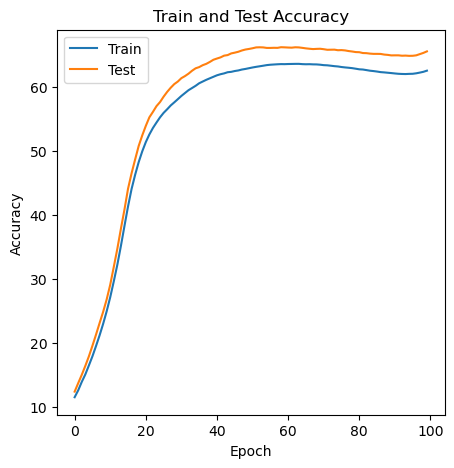

In [6]:
train_accuracy_cpu = torch.tensor(train_accuracy, device='cpu')
test_accuracy_cpu = torch.tensor(test_accuracy, device='cpu')

plt.figure(figsize=(5,5))
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(torch.arange(epochs), train_accuracy_cpu, label='Train')
plt.plot(torch.arange(epochs), test_accuracy_cpu, label='Test')
plt.legend()

#### Visualize Convolutional Layers

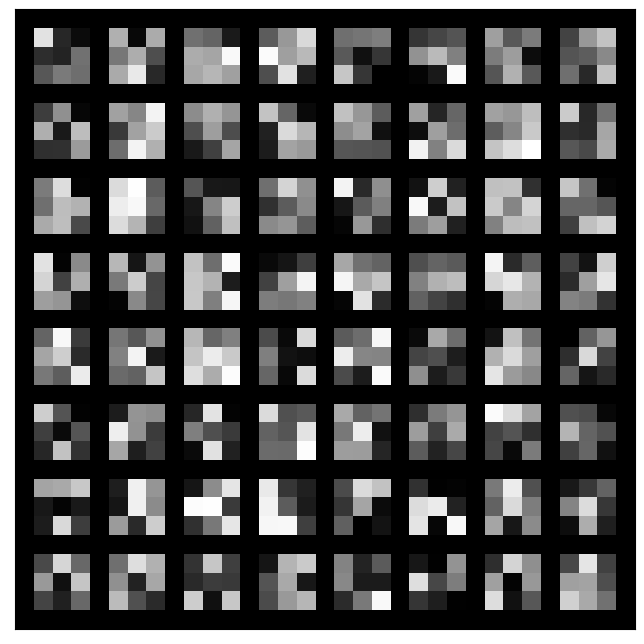

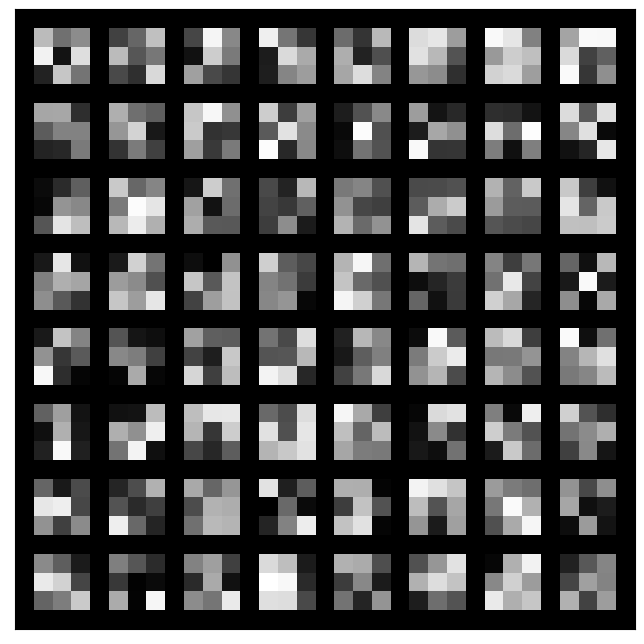

In [7]:
from torchvision import utils
import numpy as np

# From https://stackoverflow.com/a/55604568
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

filters = model[0].weight.data.cpu().clone()
visTensor(filters)

filters = model[3].weight.data.cpu().clone()
visTensor(filters)